# Contextual Retrieval-Augmented Generation (RAG) System
*(Developed by Anthropic, which reduces retrieval error rates by 67%)*

## Introduction

Welcome to this comprehensive guide on building a cutting-edge **Contextual Retrieval-Augmented Generation (RAG)** system for question answering. RAG systems merge the strength of large language models with external knowledge retrieval, enabling more precise, current, and evidence-backed responses.

In this guide, we'll break down the implementation of a **Contextual RAG system** into its core components. This modular approach will help you understand and customize each part based on your specific requirements.

### What is RAG?

**RAG (Retrieval-Augmented Generation)** is a technique that enhances language models by integrating external knowledge retrieval. Instead of relying only on the information stored in the model's parameters, RAG systems can pull relevant information from external knowledge bases or documents and incorporate it into their generated responses. This results in outputs that are not only more accurate but also up-to-date and factually grounded.

###  Implementation

In this notebook, we will build a Contextual RAG system with the following critical components you can see the how the contexutal retrival works in below diagram: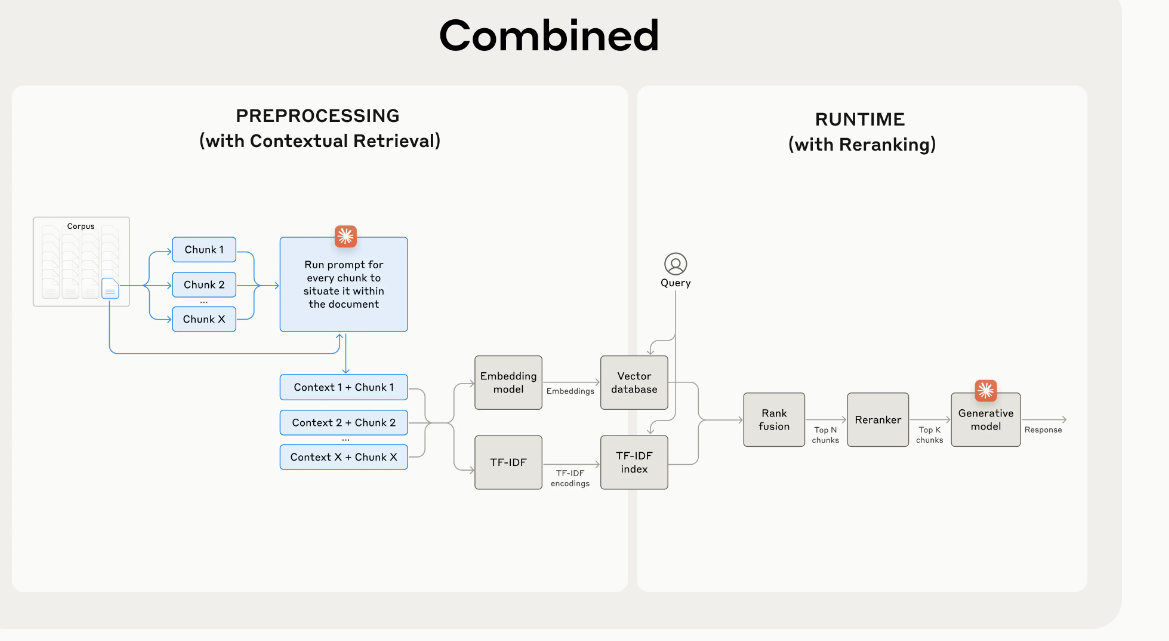

1. **Document Processing**: Preprocessing and organizing the source documents for efficient retrieval.
2. **Contextual Chunk Creation**: Dividing documents into contextually meaningful chunks to improve retrieval granularity.
3. **Vector Database Storage**: Storing document chunks in a vector database for fast retrieval.
4. **Hybrid Search**: Combining **dense** (vector-based) and **sparse** (keyword-based) retrieval for better results.
5. **Reranking**: Refining search results to prioritize the most relevant content.
6. **Response Generation**: Using retrieved information to generate a coherent and accurate response.




By the end of this guide, you will have a fully functional RAG system capable of answering questions based on a given document corpus.

---

## 1. Setup and Installation

Before building our RAG system, we need to prepare the environment and install the necessary libraries. Follow the steps outlined below to get everything up and running.

### Required Libraries

We will use several libraries that are specialized for different parts of the RAG pipeline:

- `langchain`: A powerful framework for building applications that utilize language models.
- `pinecone-client`: For managing vector database operations.
- `cohere`: To leverage advanced natural language processing tasks such as reranking.
- `rank_bm25`: For implementing the BM25 algorithm, a standard in keyword-based retrieval.
- `google-generativeai`: For accessing Google's advanced generative AI models.
- `transformers`: Hugging Face's library for state-of-the-art natural language processing.
- `torch`: PyTorch for deep learning and model operations.
- `pypdf` and `PyPDF2`: For parsing and handling PDF documents.
- `langchain_google_genai`: Integration between LangChain and Google Generative AI.

### Installation

To install the necessary packages, run the following `pip` commands in your terminal or notebook:


In [ ]:
!pip install langchain pinecone-client cohere rank_bm25 google-generativeai transformers torch pypdf PyPDF2 langchain_google_genai

## API Key Setup

To use our RAG system, you'll need to obtain API keys from three services: Pinecone, Cohere, and Google AI. Here's how to get each key and set them up in your environment:

### 1. Pinecone API Key

Pinecone is our vector database service. To get an API key:

1. Go to [Pinecone's website](https://www.pinecone.io/) and sign up for an account.
2. Once logged in, navigate to your dashboard.
3. Look for the API key section. You should see a key that looks like a long string of letters and numbers.

### 2. Cohere API Key

Cohere provides our reranking capability. To obtain a Cohere API key:

1. Visit [Cohere's website](https://cohere.ai/) and create an account.
2. After logging in, go to your dashboard or settings page.
3. You should find an option to generate or view your API key.

### 3. Google AI API Key

We use Google's Generative AI for embeddings and the Gemini model. To get a Google AI API key:

1. Go to the [Google AI Studio](https://makersuite.google.com/app/apikey).
2. If you don't have an account, you'll need to create one and set up a project.
3. Once in the API section, you can create a new API key.

### Setting Up Your API Keys

Once you have all three API keys, you need to set them as environment variables in your Python environment. Here's how to do it:




In [ ]:
import os
import uuid
import google.generativeai as genai
from typing import List, Dict, Any
from rank_bm25 import BM25Okapi
from pinecone import Pinecone
import cohere
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from PyPDF2 import PdfReader
# Set up API keys

os.environ["PINECONE_API_KEY"] = "your_pinecone_api_key_here"
os.environ["COHERE_API_KEY"] = "your_cohere_api_key_here"
os.environ["GOOGLE_API_KEY"] = "your_google_ai_api_key_here"

#  Initialize clients
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("document")

cohere_client = cohere.Client(os.getenv("COHERE_API_KEY"))

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# Initialize Gemini model
gemini_model = genai.GenerativeModel(model_name='gemini-1.5-flash')

# Initialize embedding model
embedding_model = GoogleGenerativeAIEmbeddings(model='models/embedding-001')

print("Setup complete!")

Setup complete!


## 2. Document Processing

The document processing stage is crucial for preparing our data for the RAG system. This module handles the ingestion of PDF documents and breaks them down into manageable chunks. Let's explore this process in detail.

### 2.1 PDF Ingestion

First, we need to extract text from PDF documents. We use the `PyPDF2` library for this task:
###2.2 Text Chunking
After extracting text from the PDF, we need to break it down into smaller, manageable chunks. This is important for two reasons:

It allows for more granular and relevant retrieval of information.
It helps to stay within token limits of embedding models.



In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def process_pdf(file_path: str) -> str:
    with open(file_path, 'rb') as file:
        pdf_reader = PdfReader(file)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text

def chunk_text(text: str, source: str) -> List[Dict[str, str]]:
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = text_splitter.split_text(text)
    return [{"content": chunk, "source": source} for chunk in chunks]

# Example usage
pdf_text = process_pdf("/content/Quintessentail.pdf")
chunks = chunk_text(pdf_text, "/content/Quintessentail.pdf")
print(f"Processed {len(chunks)} chunks from the PDF.")

Processed 14 chunks from the PDF.


## 3. Contextual Chunk Creation

The Contextual Chunk Creation module is a crucial step in enhancing the quality of our retrieval system. By generating context for each chunk, we improve the system's understanding of the content and its ability to retrieve relevant information. Let's dive into how this works.

### 3.1 Why Context Matters

Before we get into the implementation, it's important to understand why we're adding context to our chunks:

1. **Improved Relevance**: Context helps the system understand how a chunk fits into the broader document.
2. **Better Embeddings**: When we generate embeddings, the added context provides more information, leading to more meaningful vector representations.
3. **Enhanced Retrieval**: With context-aware chunks, our retrieval system can make more informed decisions about which chunks are most relevant to a query.

### 3.2 Generating Chunk Context

We use the Gemini model to generate context for each chunk. Here's how it works:




In [ ]:
def generate_chunk_context(chunk_content: str) -> str:
    prompt = f"""Given the following text chunk, provide a brief context that situates this chunk within the overall document:

    {chunk_content}

    Context:"""
    response = gemini_model.generate_content(prompt)
    return response.text

def create_contextualized_chunks(chunks: List[Dict[str, str]]) -> List[Dict[str, str]]:
    contextualized_chunks = []
    for chunk in chunks:
        context = generate_chunk_context(chunk['content'])
        contextualized_chunks.append({
            "content": chunk['content'],
            "context": context,
            "source": chunk['source']
        })
    return contextualized_chunks

# Example usage
contextualized_chunks = create_contextualized_chunks(chunks)
print(f"Created {len(contextualized_chunks)} contextualized chunks.")

Created 14 contextualized chunks.


## 4. Vector Database Storage

This module stores our contextualized chunks in Pinecone, a vector database optimized for similarity search.

### Key Concepts:

1. **Vector Embedding**: We convert each contextualized chunk into a vector using GoogleGenerativeAIEmbeddings.

2. **Metadata**: Along with the vector, we store metadata including the original content, context, and source.

3. **Pinecone Index**: We use a pre-configured Pinecone index to store our vectors and metadata.



### Process:


1. Generate embeddings for each chunk
2. Prepare metadata
3. Insert vectors and metadata into Pinecone

### Impact:

This step sets the foundation for fast, relevant information retrieval in our RAG system, enabling us to quickly find similar chunks when processing user queries.


In [ ]:
def store_in_vector_database(contextualized_chunks: List[Dict[str, str]]):
    contextualized_texts = [
        f"{chunk['context']} {chunk['content']}"
        for chunk in contextualized_chunks
    ]
    embeddings = embedding_model.embed_documents(contextualized_texts)

    vectors = [
        (
            str(uuid.uuid4()),
            embedding,
            {
                "content": chunk["content"],
                "context": chunk["context"],
                "source": chunk["source"]
            }
        )
        for chunk, embedding in zip(contextualized_chunks, embeddings)
    ]

    index.upsert(vectors=vectors)
    print(f"Stored {len(vectors)} vectors in Pinecone.")

# Example usage
store_in_vector_database(contextualized_chunks)

Stored 14 vectors in Pinecone.


## 5. Hybrid Search

This module enhances our RAG system by combining dense (vector) and sparse (BM25) retrieval methods for more robust and accurate search results.

### Key Components:

1. **Dense Retrieval**: Uses vector similarity search in our Pinecone database.
2. **Sparse Retrieval**: Implements BM25 algorithm for keyword-based search.
3. **Result Fusion**: Combines results from both methods.

### Process:

1. **Vector Search**: Query the Pinecone index to find similar vectors.
2. **BM25 Search**: Use BM25Okapi to find relevant documents based on keyword matching.
3. **Result Combination**: Merge and rank results from both methods.

### Importance:

- **Complementary Strengths**: Vector search excels at semantic similarity, while BM25 is strong in keyword matching.
- **Improved Relevance**: Captures both semantic meaning and keyword importance.
- **Robustness**: Helps mitigate weaknesses of each individual method.



In [ ]:
def create_bm25_index(contextualized_chunks: List[Dict[str, str]]):
    corpus = [f"{chunk['context']} {chunk['content']}" for chunk in contextualized_chunks]
    return BM25Okapi([doc.split() for doc in corpus])

def hybrid_search(query: str, bm25, contextualized_chunks: List[Dict[str, str]], k: int = 10) -> List[Dict[str, Any]]:
    # Dense retrieval
    query_embedding = embedding_model.embed_query(query)
    dense_results = index.query(vector=query_embedding, top_k=k, include_metadata=True)

    # Sparse retrieval
    tokenized_query = query.split()
    bm25_scores = bm25.get_scores(tokenized_query)
    bm25_results = sorted(enumerate(bm25_scores), key=lambda x: x[1], reverse=True)[:k]

    # Combine results with error handling
    combined_results = [
        {
            "content": match.metadata.get("content", ""),
            "context": match.metadata.get("context", "No context available"),
            "source": match.metadata.get("source", "Unknown source"),
            "score": match.score
        } for match in dense_results.matches
    ] + [
        {
            "content": contextualized_chunks[idx]["content"],
            "context": contextualized_chunks[idx].get("context", "No context available"),
            "source": contextualized_chunks[idx].get("source", "Unknown source"),
            "score": score
        } for idx, score in bm25_results
    ]

    # Remove duplicates and sort
    seen = set()
    unique_results = []
    for result in combined_results:
        if result["content"] not in seen:
            seen.add(result["content"])
            unique_results.append(result)

    return sorted(unique_results, key=lambda x: x["score"], reverse=True)[:k]

# # Example usage remains the same
# bm25 = create_bm25_index(contextualized_chunks)
# search_results = hybrid_search("Your query here", bm25, contextualized_chunks)

## 6. Reranking

Reranking improves search result relevance using Cohere's reranking model.

Key points:
- Takes initial search results and reorders them based on relevance to the query
- Uses Cohere's `rerank` function with the 'rerank-english-v2.0' model
- Improves precision of top results


In [ ]:
def rerank(query: str, results: List[Dict[str, Any]], k: int = 5) -> List[Dict[str, Any]]:
    rerank_response = cohere_client.rerank(
        model='rerank-english-v2.0',
        query=query,
        documents=[f"{r['context']} {r['content']}" for r in results],
        top_n=k
    )

    reranked = []
    for rerank_result in rerank_response.results:
        original = results[rerank_result.index]
        reranked.append({
            **original,
            "rerank_score": rerank_result.relevance_score
        })

    return sorted(reranked, key=lambda x: x["rerank_score"], reverse=True)

# Example usage
# reranked_results = rerank("Your query here", search_results)


## 7. Response Generation

This module generates the final answer using the
Gemini model.

Process:
1. Combines query and top-ranked chunks into a prompt
2. Sends prompt to Gemini model
3. Returns generated response

Importance: Produces coherent, context-aware answers based on retrieved information


In [ ]:
def generate_response(query: str, context: List[Dict[str, Any]]) -> str:
    context_str = "\n\n".join([f"Context: {c['context']}\nContent: {c['content']}" for c in context])
    prompt = f"""Given the following context and query, generate a comprehensive answer:

    Context:
    {context_str}

    Query: {query}

    Answer:"""

    response = gemini_model.generate_content(prompt)
    return response.text

# Example usage
# final_response = generate_response("Your query here", reranked_results)
# print(f"Response: {final_response}")


## 8. Contextual Retrival

This class combines all previous modules into a complete contextual retrival RAG system.

Components:

- Document processing
- Contextual chunk creation
- Vector database storage
- Hybrid search
- Reranking
- Response generation



In [ ]:
class ModularRAG:
    def __init__(self, pdf_path: str):
        self.pdf_path = pdf_path
        self.chunks = []
        self.contextualized_chunks = []
        self.bm25 = None

    def process_document(self):
        pdf_text = process_pdf(self.pdf_path)
        self.chunks = chunk_text(pdf_text, self.pdf_path)
        self.contextualized_chunks = create_contextualized_chunks(self.chunks)
        store_in_vector_database(self.contextualized_chunks)
        self.bm25 = create_bm25_index(self.contextualized_chunks)

    def answer_query(self, query: str):
        search_results = hybrid_search(query, self.bm25, self.contextualized_chunks)
        reranked_results = rerank(query, search_results)
        return generate_response(query, reranked_results)

    def retrieve(self, query: str, k: int = 5) -> List[Dict[str, Any]]:
        return hybrid_search(query, self.bm25, self.contextualized_chunks, k)

# Usage
rag_system = ModularRAG("/content/Quintessentail.pdf")
rag_system.process_document()

# Now you can ask multiple queries
query1 = "What is the main topic of this document?"
answer1 = rag_system.answer_query(query1)
print(f"Query: {query1}\nAnswer: {answer1}\n")

query2 = "What technologies are used to develop this intelligent enterprise assistant?"
answer2 = rag_system.answer_query(query2)
print(f"Query: {query2}\nAnswer: {answer2}")

Stored 14 vectors in Pinecone.
Query: What is the main topic of this document?
Answer: The main topic of this document is the promotion of an **Intelligent Enterprise Assistant**, an AI-powered chatbot solution designed for large organizations. 

The document focuses on showcasing the solution's:

* **Innovation and value:**  Highlighting the use of advanced AI technologies like Retrieval-Augmented Generation (RAG) and its potential to disrupt traditional enterprise operations.
* **Credibility and readiness:**  Emphasizing the solution's production-ready status, positive feedback from industry experts, and alignment with ESG goals.
* **Unique features and benefits:**  Describing the solution's 24/7 availability, scalability, security, continuous learning, and cost-saving potential.
* **Specific capabilities:**  Focusing on features like personalized reinforcement learning, real-time knowledge management, employee engagement, multilingual support, and advanced analysis.
* **Integration 

In [ ]:
!pip install stable-baselines3[extra] gym


## 9. RLHF+RAG Integration

Enhances the RAG system with Reinforcement Learning from Human Feedback (RLHF).

Key concepts:
- Uses PPO (Proximal Policy Optimization) for reinforcement learning
- Creates an environment (RLHFEnv) that represents the RAG system's state and actions
- Allows the system to improve based on user feedback


In [ ]:
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
class RLHFEnv(gym.Env):
    def __init__(self, rag_system: ModularRAG):
        super(RLHFEnv, self).__init__()
        self.rag_system = rag_system
        self.action_space = spaces.Discrete(2)  # 0: Use RAG response, 1: Improve response
        self.observation_space = spaces.Box(low=-1, high=1, shape=(768*2,), dtype=np.float32)
        self.current_query = None
        self.current_response = None

    def reset(self):
        self.current_query = None
        self.current_response = None
        return np.zeros(768*2, dtype=np.float32)

    def step(self, action):
        if self.current_query is None:
            raise ValueError("Environment not initialized with a query. Call 'set_query' first.")

        if action == 0:
            self.current_response = self.rag_system.answer_query(self.current_query)
        else:
            initial_response = self.rag_system.answer_query(self.current_query)
            self.current_response = self.improve_response(self.current_query, initial_response)

        reward = self.get_user_feedback()
        done = True
        info = {}
        observation = self.get_observation(self.current_query)

        return observation, reward, done, info

    def set_query(self, query):
        self.current_query = query
        return self.get_observation(query)

    def get_observation(self, query):
        query_embedding = embedding_model.embed_query(query)
        retrieved_chunks = self.rag_system.retrieve(query)
        if retrieved_chunks:
            context_embedding = np.mean([embedding_model.embed_query(c['content']) for c in retrieved_chunks], axis=0)
        else:
            context_embedding = np.zeros_like(query_embedding)
        return np.concatenate([query_embedding, context_embedding]).astype(np.float32)  # Ensure float32 type


    def improve_response(self, query, initial_response):
        prompt = f"Improve the following response to the query:\n\nQuery: {query}\n\nInitial response: {initial_response}\n\nImproved response:"
        improved_response = gemini_model.generate_content(prompt)
        return improved_response.text

    def get_user_feedback(self):
        print(f"\nQuery: {self.current_query}")
        print(f"Response: {self.current_response}")
        feedback = float(input("Please rate the response (0-1, where 1 is best): "))
        return feedback


## 10. RLHFRAG Class

Integrates RAG with RLHF in a single system.

Features:
- Combines ModularRAG functionality with RLHF capabilities
- Includes methods for processing documents, answering queries, and training the RLHF model
- Provides an interactive loop for continuous learning from user feedback
HF:


In [ ]:
class RLHFRAG:
    def __init__(self, pdf_path: str):
        self.rag_system = ModularRAG(pdf_path)
        self.env = RLHFEnv(self.rag_system)  # Use the environment directly, not wrapped
        self.model = PPO("MlpPolicy", DummyVecEnv([lambda: self.env]), verbose=1)

    def process_document(self):
        self.rag_system.process_document()

    def train_rlhf(self, total_timesteps=1000):
        self.model.learn(total_timesteps=total_timesteps)

    def answer_query(self, query: str):
        obs = self.env.set_query(query)  # Directly call set_query on the environment
        action, _states = self.model.predict(obs, deterministic=True)
        obs, reward, done, info = self.env.step(action)  # Pass action directly, not as a list
        return self.env.current_response  # Access current_response directly



    def interactive_loop(self, num_queries=5):
        for i in range(num_queries):
            query = input("Enter your query: ")
            try:
                answer = self.answer_query(query)
                print(f"Answer: {answer}\n")
            except Exception as e:
                if i == num_queries - 1:
                    print(f"Error occurred on the last query: {str(e)}")
                    print("Completing the execution...")
                    break
                else:
                    print(f"An error occurred: {str(e)}")
                    print("Continuing to the next query...")

        # Train after a batch of queries
        try:
            self.train_rlhf()
        except Exception as e:
            print(f"Error during training: {str(e)}")

        print("Interactive loop completed.")


## 11. Usage

Demonstrates how to use the RLHFRAG system:

1. Initialize the system with a PDF document
2. Process the document
3. Run an interactive loop to answer queries and gather feedback
4. Train the RLHF model based on accumulated feedback

This setup creates a dynamic, self-improving question-answering system that combines the strengths of RAG and RLHF.

In [ ]:
# Initialize and process document
rlhf_rag_system = RLHFRAG("/content/Quintessentail.pdf")
rlhf_rag_system.process_document()

# Run interactive loop
rlhf_rag_system.interactive_loop(num_queries=5)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Stored 14 vectors in Pinecone.
Enter your query: What are the cloud technologies being employed for this intelligent enterprise agent project?

Query: What are the cloud technologies being employed for this intelligent enterprise agent project?
Response: The intelligent enterprise agent leverages several cloud technologies from AWS (Amazon Web Services) for its infrastructure and scalability:

* **AWS Lambda:** Serverless compute service enabling the agent to scale automatically based on demand.
* **AWS S3 (Simple Storage Service):**  Provides secure and scalable storage for data and assets used by the agent.
* **AWS API Gateway:** Manages and secures all the APIs used by the agent, ensuring reliable communication and data exchange. 

These AWS services combined contribute to the agent's  **scalability, security, and performance**. 

Please rate the response (0-1, where 1 is best): 0.8
Answer: The intelligent enterprise agent leverages several cloud technologies from A

## END

Thank you for following along with this notebook on building a **Contextual Retrieval-Augmented Generation (RAG) System**. We hope this guide has helped you understand the process of combining external knowledge retrieval with language models to create more accurate and reliable question-answering systems.

To recap, we’ve covered:

- Document processing and contextual chunk creation for enhanced retrieval precision.
- Using a vector database and hybrid search to improve retrieval performance.
- How to rerank search results and generate coherent responses by integrating external knowledge.

This modular approach to RAG enables a flexible, scalable system that can be applied to a variety of real-world applications, including customer support, research assistance, and interactive chatbots.

We encourage you to experiment with the components discussed here, customize the pipeline based on your specific needs, and explore potential optimizations in the retrieval and generation stages.

Happy coding, and we look forward to seeing what you build!

*Thanks for reading the notebook!*
